## Data extraction

In [1]:
def run_dat_extract(path, country):
    %load_ext autoreload
    %autoreload 2
    #plt.rcParams['figure.figsize'] = (16,8)

    ## Import data

    import pandas as pd
    from purchase_prediction.import_data import import_transaction_club, import_transaction_ecom, import_sfid_email_ecom

    #_set_params
#     path = 'u:\\Projects\\datasets\\customer_history\\spring_special_2020'
#     country = 'PL'

    # Import Club Customers
    df_club = import_transaction_club(country=country, 
                                      start_observation_period='01012018', 
                                      end_observation_period='01012020',
                                      path=path )
    # Import ECom NonClub Customers
    df_etmp = import_transaction_ecom(country=country, 
                                      start_observation_period='01012018', 
                                      end_observation_period='01012020',
                                      path=path)
    # Import keys linking mails and SFID
    df_keys = import_sfid_email_ecom('Export_ClientInfo20200131.csv')
    # Select these customers that have a valid email from ECom NonClub
    df_ecom = df_etmp.merge(df_keys, on= 'Email', how='inner')
    print(str(df_etmp.shape[0] - df_ecom.shape[0])+' lost ECom non Club customers based on Email merge')

    ## Munge data

    from purchase_prediction.munging_pipeline import (start_pipeline, 
                                                      select_valid_cards, 
                                                      lower_cols, 
                                                      def_types, 
                                                      down_sample,
                                                      correct_timestamps, 
                                                      correct_for_retourned,
                                                      drop_retours,
                                                      assign_customer_type
                                             )

    from purchase_prediction.munging_pipeline_ecom import (rename_cols_ecom,
                                                           correct_timestamps_ecom,
                                                           def_types_ecom,
                                                           drop_cols
                                                   )

    df_club_clean = (df_club
    .pipe(start_pipeline)
    .pipe(select_valid_cards)
    .pipe(lower_cols)            
    .pipe(correct_timestamps)
    .pipe(def_types)
    #.pipe(down_sample, threshold=50000)
    #.pipe(correct_for_retourned) # This steps is very long (should be optimized). Only use if monetary value required.
    .pipe(drop_retours)   
    .pipe(assign_customer_type,label='club')
    )

    print('')
    print('There are ' + str(df_club_clean.groupby(by='customer_salesforce_id').count().shape[0]) + ' club customers.')

    # df_club_clean.head(1)

    df_ecom_clean = (df_ecom
    .pipe(start_pipeline)
    .pipe(rename_cols_ecom)
    .pipe(correct_timestamps_ecom)            
    .pipe(def_types_ecom)
    .pipe(drop_cols)   
    .pipe(assign_customer_type, label='ecom_nonclub')
    )

    print('There are ' + str(df_ecom_clean.groupby(by='eshop_id').count().shape[0]) + ' Ecom non club customers.')
    print('')

    # df_ecom_clean.head(1)

    from purchase_prediction.ml_pipeline import (select_recent_members, 
                                                 date_benchmarking, 
                                                 compute_age_recency, 
                                                 rename_cols, 
                                                 select_ml_data, 
                                             )

    from purchase_prediction.ml_pipeline_ecom import (select_receipt_dates_ecom, 
                                                      compute_age_recency_ecom, 
                                                      rename_cols_ecom_ml, 
                                                      add_frequency, 
                                                      select_ml_data_ecom, 
                                                 )
    now_time_reference = '2020-01-01T00'
    df_club_ml = (df_club_clean
    .pipe(start_pipeline)
    .pipe(select_recent_members,
    timestamp_bef='2018-01-01T00',
    timestamp_aft=now_time_reference,
    action = "between")
    .pipe(date_benchmarking, upper_benchmark=now_time_reference)
    .pipe(compute_age_recency,timestamp_ref=now_time_reference)
    .pipe(rename_cols)
    .pipe(select_ml_data)
    )

    lost_customers = df_club_clean.groupby(by='club_card_number').count().shape[0] - df_club_ml.groupby(by='club_card_number').count().shape[0]
    print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
    print('#Customers select for ML pipeline = ' + str(df_club_ml.groupby(by='club_card_number').count().shape[0]))

    df_ecom_ml = (df_ecom_clean
    .pipe(select_receipt_dates_ecom, upper_benchmark=now_time_reference)
    .pipe(compute_age_recency_ecom,timestamp_ref=now_time_reference)
    .pipe(rename_cols_ecom_ml)
    .pipe(add_frequency)
    .pipe(select_ml_data_ecom)              
         )

    lost_customers = df_ecom_clean.groupby(by='sfid').count().shape[0] - df_ecom_ml.groupby(by='sfid').count().shape[0]
    print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
    print('#Customers select for ML pipeline = ' + str(df_ecom_ml.groupby(by='club_card_number').count().shape[0]))

    # POOLING CLUB & ECOM
    df_ml = (pd.concat([df_club_ml, df_ecom_ml], axis=0, join='outer', sort=False)
    .dropna() # Some customers have missing SFID
    )
    df_ml.head(5)
    return df_ml

## Model fit & test

In [2]:
def run_model():
    # Import models
    from lifetimes import BetaGeoFitter,ParetoNBDFitter
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    #bgf_Pareto = ParetoNBDFitter(penalizer_coef=0.1)

    # Verify that the model is doing a relatively good job at predicting values
    from lifetimes.utils import calibration_and_holdout_data
    # This function creates a summary of each customer over a calibration and holdout period (training and testing)
    # It accepts transaction data, and returns a DataFrame of sufficient statistics.
    summary_cal_holdout = calibration_and_holdout_data(df_ml, 'sfid', 'receipt_issue_date',
                                                        calibration_period_end='2019-01-01',
                                                        observation_period_end='2020-01-01',
                                                        freq='W',
                                                        monetary_value_col = 'monetary_value')

    from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

    bgf.fit(summary_cal_holdout['frequency_cal'], 
            summary_cal_holdout['recency_cal'], 
            summary_cal_holdout['T_cal'])
    plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

    # Model summary
    print('Model Summary')
    print(bgf.summary)

    ## Model fit over all data to predict 2020

    # Transform transaction data into customer-based data with three attributes
    from lifetimes.utils import summary_data_from_transaction_data

    summary = summary_data_from_transaction_data(df_ml, 
                                                 'sfid', 
                                                 'receipt_issue_date', 
                                                 observation_period_end='2020-01-01',
                                                 datetime_format = '%Y-%m-%d',
                                                 freq='W',
                                                 monetary_value_col = 'monetary_value')
    print('Sample of ML data')
    print(summary.sample(2))
    print('')

    from lifetimes import BetaGeoFitter

    # similar API to scikit-learn and lifelines.
    # I am using some penalizer due to low sample size, see lifetimes documentation.
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])
    print(bgf.summary)

    # Add predicted purchases to summary dataframe
    # Predicted purchases are calculated for a given time window t
    t = 4
    summary['pred_purch_coming_week=' + str(t)] = (bgf.conditional_expected_number_of_purchases_up_to_time
                                                   (
                                                    t, 
                                                    summary['frequency'], 
                                                    summary['recency'], 
                                                    summary['T']
                                                   )
                                                  )

    from lifetimes.plotting import plot_period_transactions
    plot_period_transactions(bgf)
    return summary

## Run the good stuff

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


47631 lost ECom non Club customers based on Email merge
f/ select_valid_cards cleaned: 595998 (i.e., 15.78% of initial data) entries from input dataf.

There are 660720 club customers.
There are 12524 Ecom non club customers.

Data cleansing yields 454437 lost customers.
#Customers select for ML pipeline = 227761
Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 12524
Model Summary
            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.326313  0.003888         0.318693         0.333934
alpha  11.662259  0.200135        11.269995        12.054523
a       0.333731  0.013337         0.307590         0.359872
b       0.949597  0.035757         0.879512         1.019681
Sample of ML data
                    frequency  recency     T  monetary_value
sfid                                                        
0035800000xyvrkAAA        1.0     12.0  44.0       36.710333
0031i000004vAVRAA2        1.0      6.0  46.0       25.990000

            coef  se(

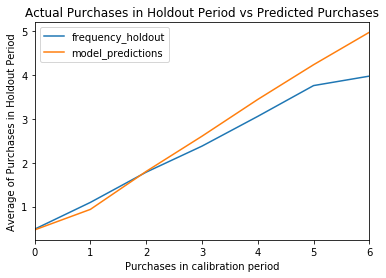

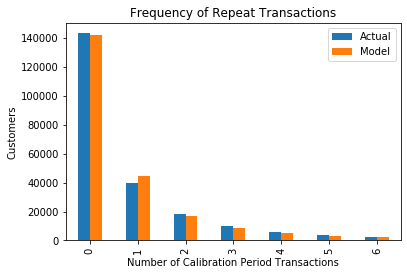

In [3]:
#_set_params
path = 'u:\\Projects\\datasets\\customer_history\\spring_special_2020'
country = 'AT'
# extract data
df_ml = run_dat_extract(path=path, country=country)

# run model
summary = run_model()

## Comparison DeFacto

We loose 21225 customers with DeFacto merging
Correlation coefficients between DeFacto and Orsay scoring:
frequency                   0.488651
recency                     0.312781
T                          -0.109780
monetary_value              0.287151
pred_purch_coming_week=4    0.559555
norm_purchase               0.559555
score                       1.000000
Name: score, dtype: float64


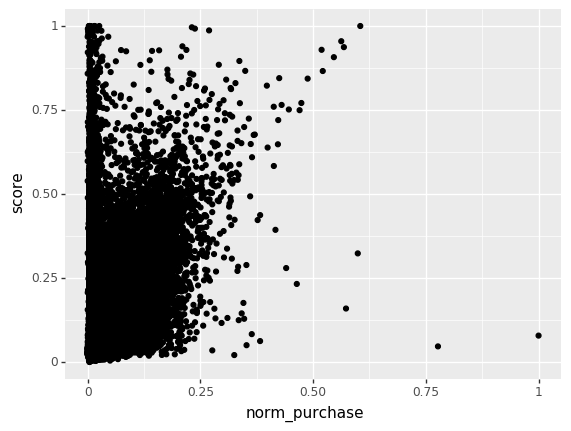

<ggplot: (-9223371887904063704)>

In [4]:
import os
import plotnine as p9
import pandas as pd

def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

path = 'u:\\Projects\\datasets\\customer_history\\DeFacto_scores'
file = 'Orsay_Promo_salesforce_January_2020.csv' # PreSale January 2020
#file = '20190913_Score_Winter_Celebration.csv'   # Winter Celebration October 2019
#file = '20191025_Winter_Presale_Daten_Score.csv' # Winter PreSale November 2019
os.chdir(path)
os.getcwd()

## Import data
files = os.listdir()
df_defacto = pd.read_csv(files[files.index(file)],sep=';', 
                          header = 0,
                          decimal=",")
df_defacto.columns = [c.lower() for c in df_defacto.columns]

df_orsay = summary.copy()
df_orsay = df_orsay.assign(norm_purchase = lambda d: normalize(d['pred_purch_coming_week=4']))
df_orsay.reset_index(level=0, inplace=True)

merged_orsay_defacto_data = df_orsay.merge(df_defacto, on='sfid', how='inner')
print('We loose ' + str(df_orsay.shape[0] - merged_orsay_defacto_data.shape[0]) + ' customers with DeFacto merging')



print('Correlation coefficients between DeFacto and Orsay scoring:')
print(merged_orsay_defacto_data.corr()['score'])

(p9.ggplot(mapping=p9.aes(x='norm_purchase', y='score'), data=merged_orsay_defacto_data)
+ p9.geom_point())